In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from aeons.utils import *
from aeons.endpoint import EndModel, theta_basic, theta_bandwidth_trunc
from aeons.regress import analytic_lm_params
from aeons.likelihoods import full
from aeons.plotting import *

In [39]:
import numpy.polynomial.polynomial as poly
def linear_regress(x, y):
    coefs = poly.polyfit(x, y, deg=1)
    return coefs

def stopping_index(logZ_start, dlogZ_predict, epsilon=1e-3):
    logZ_predicted = logZ_start + dlogZ_predict.cumsum()
    logZ_tot = logZ_predicted[-1]
    logZ_f = np.log(1 - epsilon) + logZ_tot
    index_f = np.argmax([logZ_predicted > logZ_f])
    return index_f

class IncrementModel(EndModel):
    # Inherit from EndModel
    def __init__(self, samples, nlive=500):
        super().__init__(samples)
        self.nlive = nlive
    
    def true_delta_logZ(self, ndead):
        """True change in logZ every <nlive> ndeads from <ndead> onward"""
        logZs = self.logZs.iloc[ndead - self.nlive: len(self.samples): self.nlive]
        return logZs.diff(1).dropna()
    
    def delta_logZ(self, ndead, steps=10):
        if ndead < steps * self.nlive:
            raise ValueError("ndead must be greater than steps*nlive")
        logZs = self.logZs.iloc[:ndead:self.nlive]
        return logZs.diff(1).dropna().iloc[-steps:]
    
    def linear_extrapolate(self, ndead, steps=10):
        deltas = self.delta_logZ(ndead, steps)
        coefs = linear_regress(deltas.index.get_level_values(0), deltas)
        index_predict = np.arange(ndead - self.nlive, len(self.samples), self.nlive)
        dlogZ_predict = poly.polyval(index_predict, coefs)
        return pd.Series(index=index_predict[dlogZ_predict > 0], data=dlogZ_predict[dlogZ_predict > 0])
    
    def exponential_extrapolate(self, ndead, steps=10):
        nlive = self.nlive
        deltas = self.delta_logZ(ndead, steps)
        deltas_index = deltas.index.get_level_values(0).values
        x = np.linspace(0, 1, len(deltas))
        theta = analytic_lm_params(np.log(deltas.values), x, d0=1)
        index_predict = np.arange(ndead, 5*len(self.samples))
        x_predict = (index_predict - deltas_index[0]) / (deltas_index[-1] - deltas_index[0])
        dlogZ_predict = np.exp(full.func(x_predict, theta))
        return pd.Series(index=index_predict[::nlive], data=dlogZ_predict[::nlive])

    def get_endpoint(self, ndead, method='exp', steps=10):
        nlive = self.nlive
        if ndead < steps*nlive:
            raise ValueError("ndead must be greater than steps*nlive")
        if method == 'linear':
            delta_logZ_predict = self.linear_extrapolate(ndead, steps)
        elif method == 'exp':
            delta_logZ_predict = self.exponential_extrapolate(ndead, steps)
        else:
            raise ValueError("Method must be 'linear' or 'exp'")
        return ndead + (stopping_index(self.logZs.iloc[ndead], delta_logZ_predict.values) - 1) * nlive

In [79]:
name, samples = get_samples('toy', 'gauss_16')
samples = pickle_in('gauss/gauss_16.pkl')
inc = IncrementModel(samples, nlive=500)
true_endpoint = inc.true_endpoint()
true_logXf = samples.logX().iloc[true_endpoint]

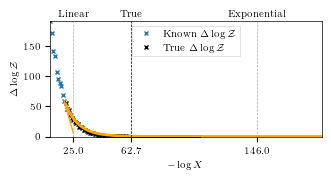

In [128]:
ndead = 10000
endpoint_linear = inc.get_endpoint(ndead, method='linear', steps=2)
endpoint_exp = inc.get_endpoint(ndead, method='exp', steps=10)
logXf_linear = endpoint_linear/-500
logXf_exp = endpoint_exp/-500

fig, ax = plt.subplots(figsize=(3.5, 1.5))

inc.delta_logZ(ndead).plot(marker='x', ms=3, ls='none', ax=ax, label='Known $\\Delta\\log\\mathcal{Z}$')
inc.true_delta_logZ(ndead).plot(color='black', marker='x', ms=3, ls='none', ax=ax, label='True $\\Delta \\log \\mathcal{Z}$')
inc.exponential_extrapolate(ndead, steps=10).plot(lw=2, ax=ax, color='orange')
inc.linear_extrapolate(ndead, steps=2).plot(lw=1, ax=ax, color='orange')

ax.axvline(true_endpoint, lw=.5, linestyle='--', color='black')
ax.axvline(x=endpoint_exp, lw=.5, linestyle='--', color='orange')
ax.axvline(x=endpoint_linear, lw=.5, linestyle='--', color='orange')
ax.set_xticks([endpoint_linear, true_endpoint, endpoint_exp], [-logXf_linear, f"{-true_logXf:.1f}", -logXf_exp])
height = 210
ax.text(endpoint_linear, height, "Linear", ha='center', va='top')
ax.text(true_endpoint, height, "True", ha='center', va='top')
ax.text(endpoint_exp, height, "Exponential", ha='center', va='top')
ax.margins(y=0)

ax.set_xlim(ndead - 5000, true_endpoint * 3)
ax.set_xlabel("$-\\log X$")
ax.set_ylabel('$\\Delta \\log \\mathcal{Z}$')
ax.legend(loc='upper center')

Text(0.5, 1.0, '$\\Delta \\log \\mathcal{Z}$ every $n_\\mathrm{live}$ samples or  $\\Delta \\log X = -1$')

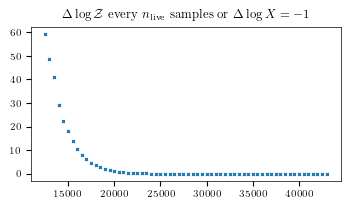

In [105]:
logZs = samples.logZs.loc[12000:]
# logZs.plot()
deltas = logZs.loc[::500].diff(1).dropna()
deltas.plot(marker='x', ls='none', ms=2)
plt.title('$\\Delta \\log \\mathcal{Z}$ every $n_\\mathrm{live}$ samples or  $\\Delta \\log X = -1$')

In [53]:
index_exp, deltas_exp = inc_points.exponential_extrapolate(ndead)
index_lin, deltas_lin = inc_points.linear_extrapolate(ndead)

In [72]:
deltas = inc_points.delta_logZ(ndead, frac=10)
coefs = linear_regress(deltas.index.get_level_values(0), deltas)
index_predict = np.arange(ndead, len(samples))
poly.polyval(index_predict, coefs)

array([   786.98804006,    785.97803664,    784.96803323, ...,
       -32837.0356859 , -32838.04568931, -32839.05569273])

In [73]:
deltas

      weights
9332  0.0        1461.670322
9832  0.0         956.668614
Name: logZs, dtype: float64

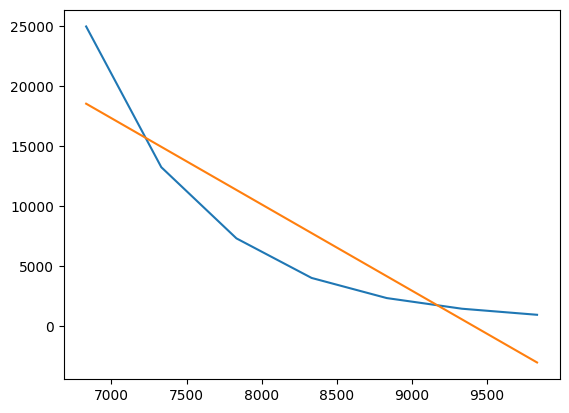

In [70]:
deltas.plot()
plt.plot(deltas.index.get_level_values(0), poly.polyval(deltas.index.get_level_values(0), coefs))

In [62]:
index_predict

array([10000, 10001, 10002, ..., 43291, 43292, 43293])

In [ ]:
poly.polyval(index_predict, coefs)dlogZ_predict = 
return index_predict[dlogZ_predict > 0], dlogZ_predict[dlogZ_predict > 0]

In [55]:
index_lin

array([], dtype=int64)

(0.0, 5000.0)

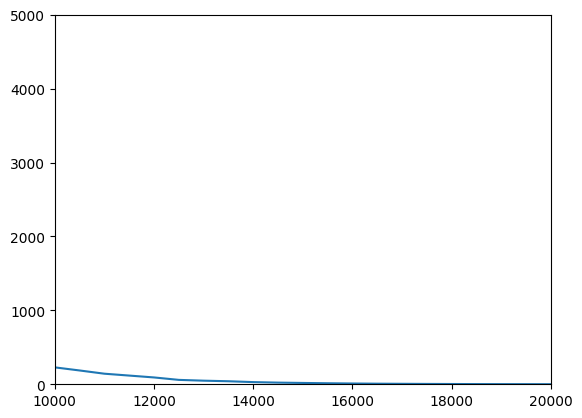

In [54]:
inc.true_delta_logZ(ndead - 1000).plot()
plt.plot(index_lin, deltas_lin)
plt.xlim(ndead, 20000)
plt.ylim(0, 5000)

In [19]:
inc_points.get_endpoint(ndead)

355500

<Axes: >

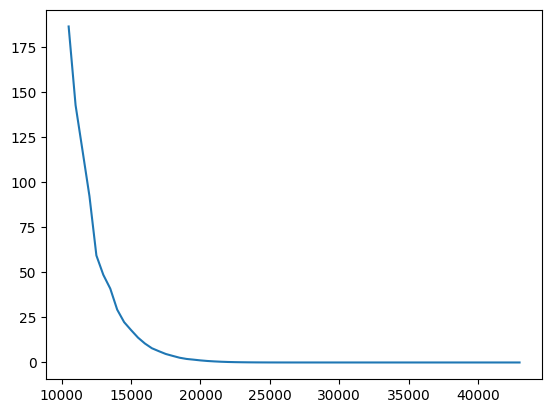

In [6]:
delta_logZ_true.plot()
# plt.ylim(0, 1)

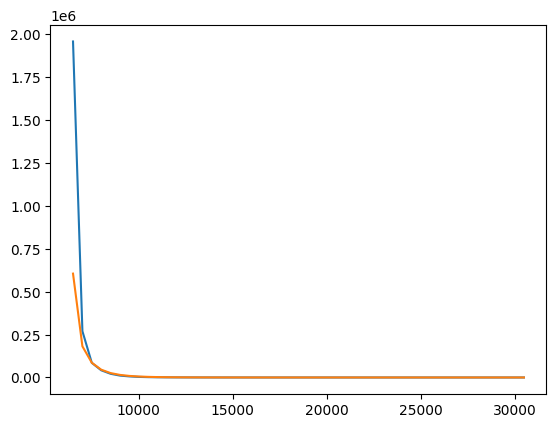

In [7]:
delta_logZ = inc_points.logZs.iloc[1000::500].diff(1).dropna()
delta_logZ= delta_logZ.rolling(len(delta_logZ)//5).mean().dropna()
delta_logZ_index = delta_logZ.index.get_level_values(0)
x = np.linspace(0, 1, len(delta_logZ))
theta = analytic_lm_params(np.log(delta_logZ), x, d0=1)
plt.plot(delta_logZ.index.get_level_values(0), delta_logZ.values)
plt.plot(delta_logZ.index.get_level_values(0), np.exp(full.func(x, theta)))

52106

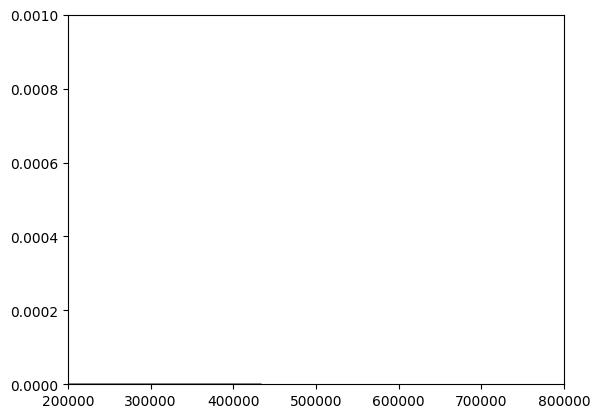

In [9]:
index_predict = np.arange(ndead, 10*len(samples))
x_predict = (index_predict - delta_logZ_index[0]) / (delta_logZ_index[-1] - delta_logZ_index[0])
dlogZ_predict = np.exp(full.func(x_predict, theta))
plt.plot(index_predict, dlogZ_predict)
# plt.plot(delta_logZ_true.index.get_level_values(0), delta_logZ_true)
plt.xlim(200000, 800000)
plt.ylim(0, 0.001)
ndead + stopping_index(inc.logZs.iloc[ndead], dlogZ_predict)

<Axes: >

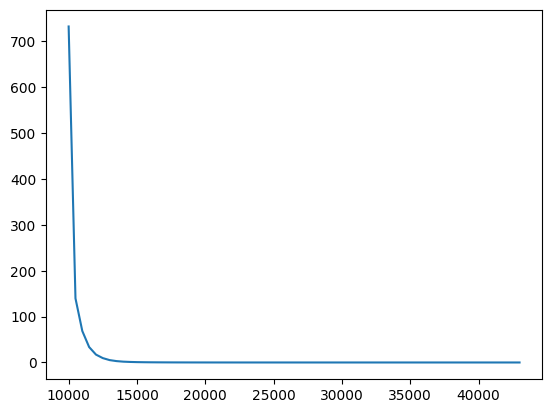

In [10]:
inc.logZs.iloc[1000:].diff(1).rolling(len(samples)//5).mean().iloc[::500].plot()

In [11]:
iteration = 40000
steps = 50
step = 100
delta_logZ = inc.delta_logZ(iteration, steps, step)
true_delta_logZ = inc.true_delta_logZ(iteration, step)
iterations = delta_logZ.index.get_level_values(0).values
index_predict, delta_logZ_predict = inc.exponential_extrapolate(iteration, steps, step)
iterations, delta_logZ.values

TypeError: IncrementModel.delta_logZ() takes from 2 to 3 positional arguments but 4 were given

In [12]:
index_predict, dlogZ_predict = inc.exponential_extrapolate(iteration, steps, step)
plt.plot(delta_logZ.index.get_level_values(0), delta_logZ.values, label='true', color='navy')
# plt.plot(true_delta_logZ.index.get_level_values(0), true_delta_logZ.values, label='true', color='navy')
plt.plot(index_predict, dlogZ_predict, label='prediction', color='orange')
inc.get_endpoint(iteration, 'exponential')

TypeError: IncrementModel.exponential_extrapolate() takes from 2 to 3 positional arguments but 4 were given

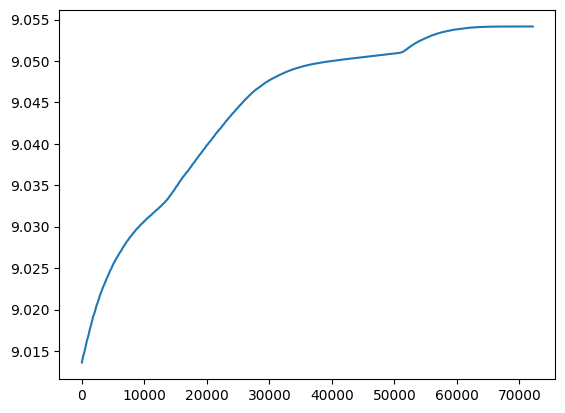

In [312]:
plt.plot(np.log(samples.logZs.values[20000:]))

In [120]:
delta_logZ.values[:-1]/delta_logZ.values[1:]

array([1.23960558, 1.21503563, 1.15811414, 1.16056538, 1.26727525,
       1.2721006 , 1.14538252, 1.24990644, 1.2091394 , 1.37656011,
       1.33302071, 1.57226125, 1.30390736, 1.59608308, 1.84398522,
       2.15477461, 2.25678823, 2.47446798, 2.77791253])

In [128]:
from aeons.regress import analytic_lm_params
from aeons.likelihoods import full

x = np.linspace(0, 1, len(delta_logZ))
theta = analytic_lm_params(np.log(delta_logZ.values), x, d0=1)
theta

[3.665964148524547, 1.6349799677044843, 0.40518622345458255]

Text(0, 0.5, '$\\Delta \\log \\mathcal{Z}$')

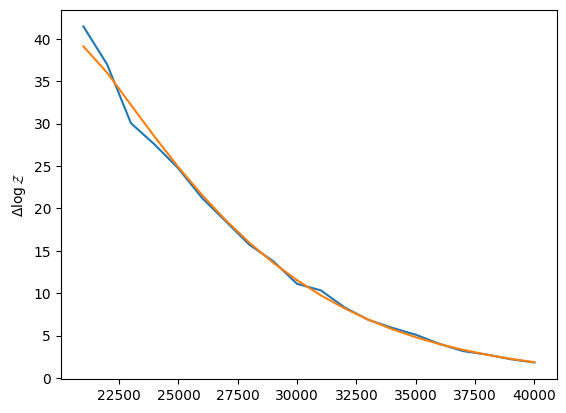

In [134]:
plt.plot(iterations, delta_logZ)
plt.plot(iterations, np.exp(full.func(x, theta)))
plt.ylabel('$\\Delta \\log \\mathcal{Z}$')

In [116]:
x = np.linspace(1, 2, 100)
step = (40000 - 21000)/100
dlogZ_predicted = np.exp(full.func(x, theta))
logZ_predicted = inc.samples.iloc[40000].logZ + np.cumsum(dlogZ_predicted)
logZ_predicted

array([-101.66030917,  -99.86930469,  -98.14466295,  -96.48406376,
        -94.88526154,  -93.34608326,  -91.8644264 ,  -90.43825692,
        -89.06560731,  -87.74457469,  -86.47331888,  -85.25006061,
        -84.07307974,  -82.94071345,  -81.85135459,  -80.80344998,
        -79.79549878,  -78.82605094,  -77.8937056 ,  -76.9971096 ,
        -76.13495604,  -75.30598281,  -74.50897119,  -73.74274452,
        -73.00616688,  -72.29814175,  -71.61761083,  -70.96355276,
        -70.33498197,  -69.73094752,  -69.15053198,  -68.59285034,
        -68.05704894,  -67.54230447,  -67.04782297,  -66.57283882,
        -66.11661385,  -65.6784364 ,  -65.25762046,  -64.85350477,
        -64.46545201,  -64.09284801,  -63.73510093,  -63.39164052,
        -63.06191739,  -62.74540229,  -62.44158539,  -62.14997566,
        -61.87010019,  -61.60150356,  -61.34374725,  -61.09640903,
        -60.85908241,  -60.63137607,  -60.41291332,  -60.20333161,
        -60.00228201,  -59.80942873,  -59.62444865,  -59.44703

In [64]:
inc.extrapolate_deltas(20000, 10, 500)

(array([20000, 20500, 21000, 21500, 22000]),
 array([24.34879843, 21.56155079, 17.86937792, 13.05069992,  6.88393688]))

In [18]:
from aeons.toy_samples import gaussian_samples
samples_10 = gaussian_samples(nlive=500, ndims=10, sigma=0.1)

In [19]:
inc_10 = IncrementModel(samples_10)

In [23]:
inc_10.true_endpoint()

10508

In [24]:
inc_10.delta_logZ(5000, 5, 1000)

      weights     
1000  9.840591e-09    19.600032
2000  6.668386e-05     9.230944
3000  1.688444e-02     6.028916
4000  2.345103e-01     3.290729
5000  7.743162e-01     1.752897
Name: logZs, dtype: float64

In [25]:
inc.delta_logZ(10000, 5, 1000)

       weights
6000   0.0        308.169270
7000   0.0        286.210257
8000   0.0        244.453624
9000   0.0        209.948267
10000  0.0        191.523545
Name: logZs, dtype: float64

## Bigchainexample

In [551]:
from anesthetic import read_chains

samples = read_chains('bigchainexample')

In [552]:
from aeons.endpoint import theta_basic
model = EndModel(samples)

In [553]:
from aeons.plotting import plot_split
plot_split(model, ndead=6600, nlive=200)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


In [381]:
logXf, logXf_std = model.logXfs(theta_bandwidth_trunc, iterations=[6600], Nset=25)
endpoint, endpoint_std = calc_endpoints([6600], model.logX_mean[6600], logXf, logXf_std, nlive=200)
endpoint, endpoint_std

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


Iteration 6600 complete, 19 samples


(array([8366.25752555]), array([58.70373039]))

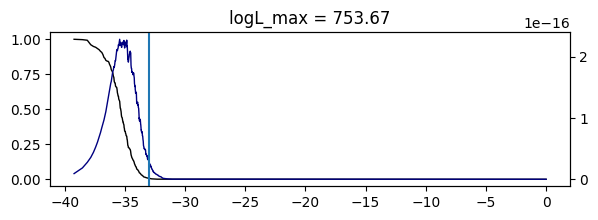

In [557]:
plot_lx(samples)
plt.axvline(x=-6600/200)

In [555]:
%matplotlib inline

## Laterbigchainexample

In [593]:
samples = read_chains('laterbigchainexample')
model = EndModel(samples)

In [596]:
samples['nlive'] = 200 * np.ones(len(samples))

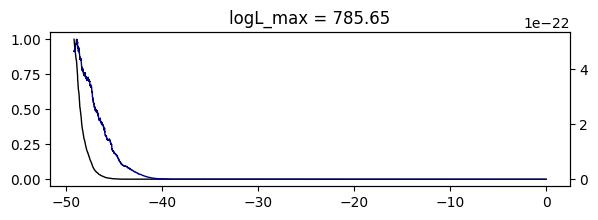

In [599]:
plot_lx(samples)

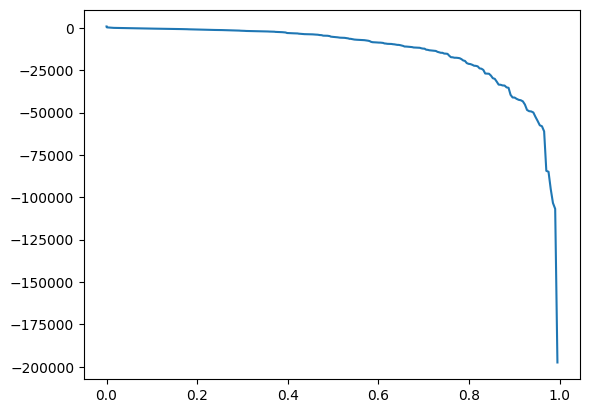

In [614]:
plt.plot(np.exp(samples.logX()), samples.logL)

In [602]:
plot_split(model, ndead=9000, nlive=200)

ValueError: Length of values (9200) does not match length of index (9198)

In [548]:
%matplotlib

Using matplotlib backend: TkAgg


In [549]:
samples.gui()

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/gui/plot.py:226: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


In [550]:
plot_lx(samples.iloc[:-200].recompute())